# Semantic Similarity Project
Author: Kesi
<br> Date: June 2025
<br> Kernel: workshop_311
<br> Goals: Compute the semantic similarity between word pairs and analyze how it affects recall ability across different stimulus conditions.

In [1]:
subj_list = ['M1005', 'M1006', 'M1007', 'M1008', 'M1011', 'M1012', 'M1013']
subject_dataframes = {}
all_cr_data = []

#Import the modules you will need for general analysis
import pprint
import numpy as np
import pandas as pd
import os
import pprint

#Import the modules you need for plotting graphs and stuff
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.gridspec import GridSpec


#### Finding the number of sessions & general experoiments' data

In [2]:
# Determine current working dierectory then define path where the patient data is located
# Use the print function to make sure it worked
# Get all folder names in the specified directory
# Filter the folder names to match the pattern 'Session_X'
# Sort the sessions in case they are not in order
# Print the result

!pwd

for subj in subj_list:
    print(f"\nProcessing Subject: {subj}")
    directory_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/'
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    sessions.sort()
    print(sessions)

/home1/kesi/semanticSimilarity

Processing Subject: M1005
[0, 1, 2, 3, 4]

Processing Subject: M1006
[0, 1, 2]

Processing Subject: M1007
[0, 1]

Processing Subject: M1008
[0, 1]

Processing Subject: M1011
[0, 1, 2, 3, 4]

Processing Subject: M1012
[0, 1, 2, 3]

Processing Subject: M1013
[0, 1]


In [3]:
# FUNCTION TO FIND STIM SITES

import json
import re

def extract_stim_sites(sessions, directory_path):
    
    stim_sites_by_session = []

    for session in sessions:
        log_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'event.log')

        # Read the log file
        try:
            with open(log_file, "r") as file:
                for line in file:
                    if '"type": "CONFIGURE"' in line:
                        try:
                            log_entry = json.loads(line.strip())
                            if "data" in log_entry and log_entry["data"]:
                                experiment = log_entry["data"].get("experiment", "N/A")
                                session_id = log_entry["data"].get("session", "N/A")
                                stim_mode = log_entry["data"].get("stim_mode", "N/A")
                                subject = log_entry["data"].get("subject", "N/A")

                                print(f'Experiment: {experiment}, Session: {session_id}, Stim Mode: {stim_mode}, Subject: {subject}')
                        except json.JSONDecodeError:
                            print(f"Error parsing JSON in {log_file}")
        except FileNotFoundError:
            print(f"Log file not found: {log_file}")
            continue
        
        # Path to the experiment.json file
        json_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'experiment_config.json')
        
        # Read and parse the JSON file
        try:
            with open(json_file, "r") as file:
                data = json.load(file)
            electrodes = data.get("experiment", {}).get("stim_channels", [{}])[0].get("electrodes", "N/A")
        except (FileNotFoundError, json.JSONDecodeError):
            print(f"Error reading JSON file: {json_file}")
            electrodes = "N/A"
        
        stim_sites_by_session.append(electrodes)
        print(f'Electrodes: {electrodes}')

    return stim_sites_by_session

#### Split up event.log into 4 phases (Encoding, Math Distractor, Cued Recall, Recognition)

In [4]:
def get_rows_between_trials(df):
    # Remove rows where 'type' is 'HEARTBEAT', 'HEARTBEAT_OK', or 'ISI'
    filtered_df = df[~df['type'].isin(['HEARTBEAT', 'HEARTBEAT_OK', 'ISI', 'word stimulus info', 'start trial'])]

    # Initialize variables
    trial_start = None
    all_trial_data = []  # Initialize to an empty list
    all_dataframes = []  # List to hold DataFrames for each trial

    # Check if there's a practice list by inspecting the rows of experimentConfig type
    practice_trial_found = False

    for index, row in filtered_df.iterrows():
        # Check for 'experimentConfig' type and inspect 'data' for 'numPracticeLists'
        # numPracticeList = df.query("type == 'experimentConfig'")['data'].iloc[0]['numPracticeLists']
        practice_trial = df.query("type == 'TRIAL'")['data'].apply(lambda x: x.get('practice', False)).any()

        # Check for the start of a new trial
        if row['type'] == 'TRIAL':
            # Process the previous trial if it exists
            if trial_start is not None and all_trial_data:
                trial_data_df = pd.DataFrame(all_trial_data)

                # Subdivide the trial DataFrame into four parts
                subdivided_dfs = []

                # Finding indices for sections with safe checks
                distract_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
                cuedrecall_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
                recog_idx = trial_data_df[trial_data_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
                
                # Determine the indices safely
                distract_idx = distract_idx[0] if not distract_idx.empty else len(trial_data_df)
                cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(trial_data_df)
                recog_idx = recog_idx[0] if not recog_idx.empty else len(trial_data_df)
                
                # Create the sections
                sections = {
                    "before_DISTRACT": trial_data_df.iloc[:distract_idx], # encoding
                    "between_DISTRACT_ORIENT": trial_data_df.iloc[distract_idx:cuedrecall_idx], # math distractor
                    "between_ORIENT_recog": trial_data_df.iloc[cuedrecall_idx:recog_idx], # cued recall
                    "after_recog": trial_data_df.iloc[recog_idx:]  # recognition
                }

                # Store each section DataFrame
                for key, section in sections.items():
                    subdivided_dfs.append(section.reset_index(drop=True))

                all_dataframes.append(subdivided_dfs)

            # Start a new trial
            trial_start = row
            all_trial_data = []  # Reset trial data collection
            
        # Collect data for the current trial
        all_trial_data.append(row.to_dict())  # Convert row to dict for DataFrame construction

    # Handle the last trial if needed
    if trial_start is not None and all_trial_data:
        last_trial_df = pd.DataFrame(all_trial_data)
        subdivided_dfs = []

        # Finding indices for the last trial sections
        distract_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
        cuedrecall_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
        recog_idx = last_trial_df[last_trial_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
        
        distract_idx = distract_idx[0] if not distract_idx.empty else len(last_trial_df)
        cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(last_trial_df)
        recog_idx = recog_idx[0] if not recog_idx.empty else len(last_trial_df)
        
        sections = {
            "before_DISTRACT": last_trial_df.iloc[:distract_idx],
            "between_DISTRACT_ORIENT": last_trial_df.iloc[distract_idx:cuedrecall_idx],
            "between_ORIENT_recog": last_trial_df.iloc[cuedrecall_idx:recog_idx],
            "after_recog": last_trial_df.iloc[recog_idx:]  # From recog to end
        }

        for key, section in sections.items():
            subdivided_dfs.append(section.reset_index(drop=True))
        
        all_dataframes.append(subdivided_dfs)

    # If a practice trial was found, delete it from all_dataframes
    if practice_trial == True:
        print('PRACTICE FOUND')
        all_dataframes = all_dataframes[1:]  # Deleting the practice trial

    return all_dataframes

In [5]:
# Skipping Math Distractor part, it's not relevant to this analysis 

In [6]:
# FUNCTION FOR PROCESSING CUED RECALL ANNOTATIONS AND CREATING A RESULTS TABLE

def process_cued_recall_data(dataframes, sessions, subj):
    """
    Processes cued recall data, extracting paired words, stimulus conditions for encoding and recall, and expected answers.
    Reads annotation files, categorizes responses, and generates a summary table.

    Parameters:
        dataframes (list): Nested list of dataframes for each session and trial.
        sessions (list): List of session identifiers.
        subj (str): Subject identifier for file paths.

    Returns:
        pd.DataFrame: Processed cued recall DataFrame with results.
        pd.DataFrame: Summary table of cued recall performance grouped by session and stimulation condition.
    """

    temp_cr_df = [[] for _ in range(len(sessions))]

    for sess in sessions:
        print(f'Session: {sess}')
        
        cues, pairedWords, stimCR, stimEnc, trials_list, instances = [], [], [], [], [], []
        
        for trial in range(len(dataframes[sess])):
            # CUED RECALL PHASE
            cr_df = dataframes[sess][trial][2]
            filtered_cr = cr_df.query("type == 'WORD'")

            for i in range(len(filtered_cr)):
                current_row = filtered_cr.iloc[i]
                pairedWords.append(current_row['data']['fullWord']['words'])  
                stimCR.append(current_row['data']['stimWord'])  
                trials_list.append(trial)  
                cues.append(current_row['data']['words'])  
                instances.append(i)

            
            # ENCODING PHASE
            enc_df = dataframes[sess][trial][0]
            filtered_enc_df = enc_df.query("type == 'WORD'")
            trial_enc_stims = []  # Store stim per encoding word

            for j in range(len(filtered_enc_df)):
                enc_row = filtered_enc_df.iloc[j]
                if enc_row['type'] == 'WORD':
                    # Capture stim status for each encoding word
                    trial_enc_stims.append(enc_row['data']['stimWord'])

            # Add stimEnc values individually (1:1 with CR words)
            stimEnc.extend(trial_enc_stims)  # ✅ Match per word pair
        temp_cr_df[sess] = pd.DataFrame({
            'session': sess,
            'trial': trials_list,
            'item': instances,
            'stimEnc': stimEnc,
            'stimCR': stimCR,
            'pairedWords': pairedWords,
            'cue': cues
        })

        temp_cr_df[sess]['nonCue'] = temp_cr_df[sess].apply(
            lambda row: [word for word in row['pairedWords'] if word not in row['cue']], axis=1)

    temp_cr_df = pd.concat(temp_cr_df, ignore_index=True)

    # ----------------------
    # PROCESS ANNOTATIONS
    # ----------------------
    data = []
    for sess in sessions:
        for trial in range(1, 13):
            for instance in range(3):
                jk_data = []
                ann_file_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/session_{sess}/task_laptop/cuedRecall_{trial}_{instance}.ann'
                
                try:
                    with open(ann_file_path, 'r') as ann_file:
                        for line in ann_file:
                            line = line.strip()
                            if line and not line.startswith('#'):
                                items = line.split('\t')
                                jk_data.append(items)
                except FileNotFoundError:
                    pass

                data.append({
                    'session': sess,
                    'trial': trial - 1,
                    'item': instance,
                    'data': jk_data
                })

    annotations = pd.DataFrame(data)

    # Merge annotations
    cr_df = pd.merge(temp_cr_df, annotations, on=['session', 'trial', 'item'], how='left')

    # DEBUG: Inspect stimEnc and stimCR values before boolean conversion
    print("Unique stimEnc values (after conversion):", cr_df['stimEnc'].unique())
    print("Unique stimCR values (after conversion):", cr_df['stimCR'].unique())

    # Convert ONLY stimEnc to boolean (since it might have 'none' strings)
    def convert_stim(value):
        if isinstance(value, bool):
            return value
        elif isinstance(value, str):
            return value != 'none'
        return False

    cr_df['stimEnc'] = cr_df['stimEnc'].apply(convert_stim)
    cr_df['stimCR'] = cr_df['stimCR'].apply(convert_stim)

    # ----------------------
    # PROCESS RESPONSES
    # ----------------------
    subj_answers = [[] for _ in range(len(cr_df))]
    results = []

    for index, row in cr_df.iterrows():
        for data_entry in row['data']:
            if data_entry[2] != '<>':
                subj_answers[index].append(data_entry[2])

        if not subj_answers[index]:
            results.append("NaN")
        elif cr_df.loc[index, 'nonCue'][0] in subj_answers[index]:
            results.append("correct")
        elif cr_df.loc[index, 'cue'][0] in subj_answers[index]:  # New condition
            results.append("read")
        else:
            results.append("intrusion")
    cr_df['results'] = results

    # ----------------------
    # SUMMARY TABLE
    # ----------------------
    stim_summary = cr_df.groupby(['session', 'stimCR'])['results'].value_counts().unstack(fill_value=0)

    for col in ['correct', 'intrusion', 'NaN']:
        if col not in stim_summary.columns:
            stim_summary[col] = 0

    stim_summary['total'] = stim_summary.sum(axis=1)

    print('Cued Recall: Results Table')
    print(stim_summary)

    return cr_df, stim_summary


In [7]:
def get_sessions_for_subject(subject, base_path='/home1/kesi/semanticSimilarity/Patient_Data'):
    directory_path = os.path.join(base_path, subject)
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    sessions.sort()
    return sessions

In [8]:
all_dataframes = {}

for subj in subj_list:
    print(f'\nProcessing Subject: {subj}')
    subj_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}'
    sessions = get_sessions_for_subject(subj)

    subject_data = []
    for sess in sessions:
        log_path = os.path.join(subj_path, f'session_{sess}', 'elemem', 'event.log')
        
        try:
            df = pd.read_json(log_path, lines=True)
            processed_trials = get_rows_between_trials(df)
            subject_data.append((sess, processed_trials))
        except Exception as e:
            print(f"Error processing {subj} session {sess}: {e}")
    
    all_dataframes[subj] = subject_data


Processing Subject: M1005
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1006
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1007
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1008
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1011
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1012
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1013
PRACTICE FOUND
PRACTICE FOUND


#### Quick Sanity Check

In [9]:
for subj, sessions_data in all_dataframes.items():
    print(f'\nSubject: {subj}')
    for session_id, trial_list in sessions_data:
        print(f'  Session {session_id}: {len(trial_list)} trials')


Subject: M1005
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials
  Session 4: 12 trials

Subject: M1006
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials

Subject: M1007
  Session 0: 12 trials
  Session 1: 12 trials

Subject: M1008
  Session 0: 12 trials
  Session 1: 12 trials

Subject: M1011
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials
  Session 4: 12 trials

Subject: M1012
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials

Subject: M1013
  Session 0: 9 trials
  Session 1: 7 trials


In [10]:
# how we get processed cued recall & summary per subject

all_cr_dataframes = {}     # stores full cued recall DataFrame per subject
all_summary_tables = {}    # stores summary table per subject

for subj in subj_list:
    print(f'\nProcessing cued recall for {subj}')
    session_trial_data = all_dataframes[subj]

    # Unpack session and trial data
    sessions = [s for s, _ in session_trial_data]
    dataframes = [t for _, t in session_trial_data]

    try:
        cr_df, summary = process_cued_recall_data(dataframes, sessions, subj)
        all_cr_dataframes[subj] = cr_df
        all_summary_tables[subj] = summary
    except Exception as e:
        print(f"Error processing {subj}: {e}")


Processing cued recall for M1005
Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Unique stimEnc values (after conversion): [False  True]
Unique stimCR values (after conversion): [False  True]
Cued Recall: Results Table
results         NaN  correct  intrusion  read  total
session stimCR                                      
0       False    24        0          0     0     24
        True     12        0          0     0     12
1       False     7        2          4    11     24
        True      2        0          5     5     12
2       False     1        7          0    16     24
        True      2        4          0     6     12
3       False     4        8          0    12     24
        True      1        3          2     6     12
4       False     7        1          7     9     24
        True      4        1          5     2     12

Processing cued recall for M1006
Session: 0
Session: 1
Session: 2
Unique stimEnc values (after conversion): [ True False]
Unique stimCR 

In [11]:
# Combine into one big DataFrame with all subjects

for subj, df in all_cr_dataframes.items():
    df['subject'] = subj
combined_cr_df = pd.concat(all_cr_dataframes.values(), ignore_index=True)


# Move subject column to front for better visibility
cols = ['subject'] + [col for col in combined_cr_df.columns if col != 'subject']
combined_cr_df = combined_cr_df[cols]

# Print the new dataframe
combined_cr_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results
0,M1005,0,0,0,False,False,"[TRIBE, LUNCH]",[TRIBE],[LUNCH],"[[8016.575963718822, -1, <>]]",NaN
1,M1005,0,0,1,False,False,"[OWL, PIN]",[OWL],[PIN],"[[8016.575963718822, -1, <>]]",NaN
2,M1005,0,0,2,False,False,"[PLANT, RAKE]",[PLANT],[RAKE],"[[8016.575963718822, -1, <>]]",NaN
3,M1005,0,1,0,False,True,"[SOUP, SKUNK]",[SOUP],[SKUNK],"[[8016.575963718822, -1, <>]]",NaN
4,M1005,0,1,1,False,True,"[PALM, BIRD]",[PALM],[BIRD],"[[8015.600907029479, -1, <>]]",NaN
...,...,...,...,...,...,...,...,...,...,...,...
796,M1013,1,4,1,False,True,"[CHURCH, MAIL]",[CHURCH],[MAIL],"[[2133.3786848072564, 148, MAIL]]",correct
797,M1013,1,4,2,False,True,"[SLIDE, SOCK]",[SLIDE],[SOCK],"[[2160.793650793651, -1, <>]]",NaN
798,M1013,1,5,0,True,False,"[BUG, SNAKE]",[BUG],[SNAKE],"[[2007.278911564626, -1, <>], [3212.4943310657...",NaN
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion


### \*\*Creating Diagrams to Display Recall Accuracy vs. Semantic Similarity\*\*

In [214]:
combined_cr_df = filtered_df.copy()

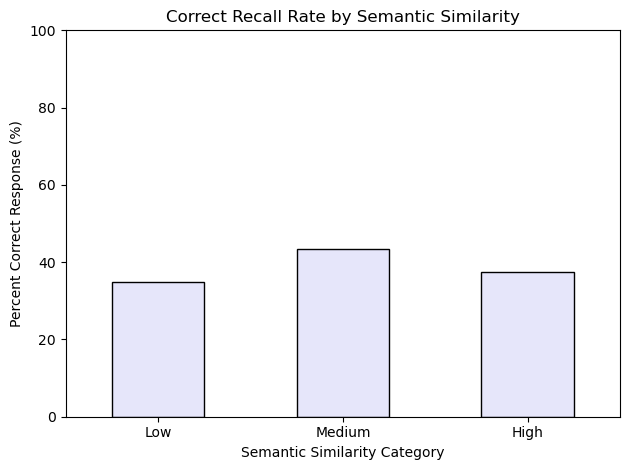

In [216]:
# Sort the dataframe by similarity
sorted_df = filtered_df.sort_values(by='similarity')

# Split into 3 equal-sized bins, based on number of items per bin, not range size
sorted_df['sim_bin'] = pd.qcut(sorted_df['similarity'], q=3, labels=['Low', 'Medium', 'High'])

# Making sure the total includes missing responses (NaN) too
def custom_percent(series):
    total = len(series)                    # Includes NaNs
    correct = (series == 'correct').sum() # Only count actual 'correct'
    return (correct / total) * 100

# Calculate percent of "correct" responses 
grouped = sorted_df.groupby('sim_bin', observed=True)
percent_correct = grouped['results'].apply(custom_percent)

# Plot the bar graph
percent_correct.plot(kind='bar', color='lavender', edgecolor='black')

# Formatting and labeling the graph
plt.ylabel('Percent Correct Response (%)')
plt.xlabel('Semantic Similarity Category')
plt.title('Correct Recall Rate by Semantic Similarity')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()                               

#### Checking that the data was broken up equally into terciles

In [217]:
sorted_df[sorted_df['sim_bin'] == 'Low']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
45,1,3,0,False,True,"[PEA, RICE]",[PEA],[RICE],0.067953,"[[662.1541950113378, 197, RICE]]",correct,Low
61,1,8,1,False,False,"[CART, GLOBE]",[CART],[GLOBE],0.094871,"[[3249.637188208617, -1, OLD], [3932.8571428571427, -1, <>], [4932.857142857143, -1, <>]]",intrusion,Low
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,Low
49,1,4,1,False,False,"[DOCK, WASP]",[DOCK],[WASP],0.119578,"[[3404.0362811791383, -1, <>]]",NaN,Low
17,0,5,2,False,True,"[DART, CHIN]",[DART],[CHIN],0.137147,"[[0.0, -1, <>], [1000.0, -1, <>], [2000.0, -1, <>], [5625.283446712018, -1, <>]]",NaN,Low
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,Low
26,0,8,2,True,False,"[APE, CARD]",[APE],[CARD],0.165837,"[[1452.3809523809523, -1, <>], [2452.3809523809527, -1, <>]]",NaN,Low
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN,Low
68,1,10,2,False,True,"[COOK, JAR]",[COOK],[JAR],0.189452,"[[5890.9977324263045, -1, <>], [6890.9977324263045, -1, <>], [7890.9977324263045, -1, <>]]",NaN,Low
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct,Low


In [218]:
sorted_df[sorted_df['sim_bin'] == 'Medium']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,Medium
12,0,4,0,False,False,"[FILM, CHEST]",[FILM],[CHEST],0.291381,"[[3069.6825396825398, -1, <>], [4069.6825396825398, -1, <>]]",NaN,Medium
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE],0.292707,"[[1727.936507936508, -1, <>], [2880.8843537414964, 188, PRINCE]]",correct,Medium
53,1,5,2,True,False,"[OX, SPRING]",[OX],[SPRING],0.299427,"[[1444.671201814059, -1, <>], [2444.671201814059, -1, <>], [3444.671201814059, -1, <>], [5304.988662131519, -1, <>], [6304.988662131519, -1, <>], [7304.988662131519, -1, <>]]",NaN,Medium
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR],0.311673,"[[1039.501133786848, 252, STAR]]",correct,Medium
66,1,10,0,False,True,"[GATE, BOOT]",[GATE],[BOOT],0.314000,"[[4179.274376417234, -1, <>], [5179.274376417234, -1, <>], [6179.274376417234, -1, <>], [7179.274376417234, -1, <>]]",NaN,Medium
33,0,11,0,False,False,"[CROWN, GEESE]",[CROWN],[GEESE],0.314459,"[[4403.469387755102, -1, <>]]",NaN,Medium
67,1,10,1,False,True,"[ROAD, CLAM]",[ROAD],[CLAM],0.322838,"[[2258.9115646258506, 53, CLAM], [3358.0725623582766, -1, <>], [5064.693877551021, -1, <>]]",correct,Medium
20,0,6,2,False,True,"[STAIR, SPOUSE]",[STAIR],[SPOUSE],0.330505,"[[2322.7437641723354, -1, <>], [3322.7437641723354, -1, <>], [4322.743764172336, -1, <>], [5322.743764172336, -1, <>], [6322.743764172336, -1, <>], [7322.743764172336, -1, <>]]",NaN,Medium
57,1,7,0,True,False,"[INK, SLUG]",[INK],[SLUG],0.331121,"[[1854.8526077097506, 230, SLUG]]",correct,Medium


In [220]:
sorted_df[sorted_df['sim_bin'] == 'High']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,High
43,1,2,1,True,False,"[VAULT, SLIDE]",[VAULT],[SLIDE],0.407662,"[[3202.5850340136058, -1, <>], [4202.585034013605, -1, <>], [5202.585034013605, -1, <>]]",NaN,High
35,0,11,2,False,False,"[CHIEF, HOLE]",[CHIEF],[HOLE],0.407807,"[[2349.5238095238096, 119, HOLE]]",correct,High
51,1,5,0,True,False,"[SHELL, MOOSE]",[SHELL],[MOOSE],0.415486,"[[1276.077097505669, 157, MOOSE]]",correct,High
41,1,1,2,False,True,"[SKATE, STREET]",[SKATE],[STREET],0.421284,"[[1132.3356009070296, 262, STREET], [5452.1768707483, -1, <>], [6452.1768707483, -1, <>]]",correct,High
14,0,4,2,False,False,"[CAGE, FRAME]",[CAGE],[FRAME],0.430342,"[[4144.331065759637, -1, <>], [4537.414965986395, 152, MAT], [4996.39455782313, -1, <>], [5558.299319727891, 95, FRAME], [7631.746031746032, 95, FRAME]]",correct,High
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,High
27,0,9,0,False,True,"[TOOL, WOLF]",[TOOL],[WOLF],0.438965,"[[2153.9455782312925, -1, <>]]",NaN,High
44,1,2,2,True,False,"[HEART, STEAM]",[HEART],[STEAM],0.441509,"[[3633.3786848072564, -1, SOUL], [4318.91156462585, -1, <>], [5318.91156462585, -1, <>], [6318.911564625851, -1, <>]]",intrusion,High
23,0,7,2,False,False,"[SHEET, TENT]",[SHEET],[TENT],0.449866,"[[3903.1519274376415, -1, <>]]",NaN,High


### Graphing the Results Accross Stimulus Conditions

In [221]:
correct_df = filtered_df[filtered_df['results'] == 'correct']
intrusion_df = filtered_df[filtered_df['results'] == 'intrusion']

In [222]:
# Adding a coulumn for stim conditions using the booleanvalues in stimEnc and stimCR
conditions = [
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == True) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

sorted_df['stim_condition'] = np.select(conditions, choices, default='unknown')
sorted_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin,stim_condition
45,1,3,0,False,True,"[PEA, RICE]",[PEA],[RICE],0.067953,"[[662.1541950113378, 197, RICE]]",correct,Low,stimCR
61,1,8,1,False,False,"[CART, GLOBE]",[CART],[GLOBE],0.094871,"[[3249.637188208617, -1, OLD], [3932.8571428571427, -1, <>], [4932.857142857143, -1, <>]]",intrusion,Low,noStim
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,Low,stimEnc
49,1,4,1,False,False,"[DOCK, WASP]",[DOCK],[WASP],0.119578,"[[3404.0362811791383, -1, <>]]",NaN,Low,noStim
17,0,5,2,False,True,"[DART, CHIN]",[DART],[CHIN],0.137147,"[[0.0, -1, <>], [1000.0, -1, <>], [2000.0, -1, <>], [5625.283446712018, -1, <>]]",NaN,Low,stimCR
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,Low,stimEnc
26,0,8,2,True,False,"[APE, CARD]",[APE],[CARD],0.165837,"[[1452.3809523809523, -1, <>], [2452.3809523809527, -1, <>]]",NaN,Low,stimEnc
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN,Low,stimEnc
68,1,10,2,False,True,"[COOK, JAR]",[COOK],[JAR],0.189452,"[[5890.9977324263045, -1, <>], [6890.9977324263045, -1, <>], [7890.9977324263045, -1, <>]]",NaN,Low,stimCR
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct,Low,noStim


In [ ]:
# Count how many are correct per group
# grouped = filtered_df.groupby(['sim_bin', 'stim_condition'])['correct'].agg(['mean', 'count'])

# Reshape into a DataFrame for plotting
# This puts stim_conditions as columns, and similarity_bin as index
# plot_data = grouped['mean'].unstack(fill_value=0)

# Sort x-axis bins in logical order
# plot_data = plot_data.reindex(['low', 'med', 'high'])

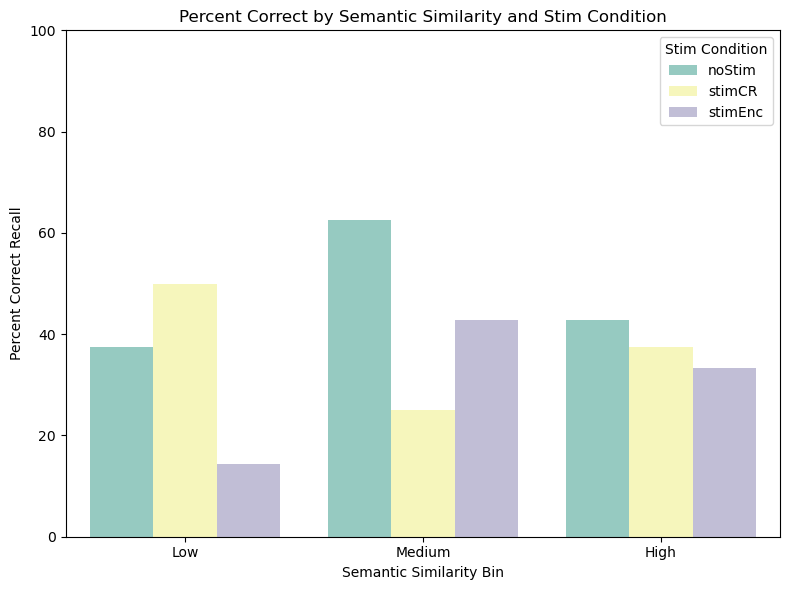

In [223]:

# Filter only correct trials
correct_df = sorted_df[sorted_df['results'] == 'correct']

# Count corrects per (sim_bin, stim_condition)
correct_counts = correct_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='correct_count')

# Count total trials per (sim_bin, stim_condition)
total_counts = sorted_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='total_count')

# Merge and calculate percent correct
merged = pd.merge(total_counts, correct_counts, on=['sim_bin', 'stim_condition'], how='left')
merged['correct_count'] = merged['correct_count'].fillna(0)  # fill missing with 0
merged['percent_correct'] = (merged['correct_count'] / merged['total_count']) * 100

# Plot grouped bar chart 
plt.figure(figsize=(8, 6))
sns.barplot(data=merged, x='sim_bin', y='percent_correct', hue='stim_condition', palette='Set3')

plt.xlabel('Semantic Similarity Bin')
plt.ylabel('Percent Correct Recall')
plt.title('Percent Correct by Semantic Similarity and Stim Condition')
plt.ylim(0, 100)
plt.legend(title='Stim Condition')
plt.tight_layout()
plt.show()

## Semantic Similarity Analyses of Intruded Words

In [238]:
# Pull intruded words from the data column
def extract_intruded_word(cell):
    matches = re.findall(r'\[.*?,.*?,\s*([^\[\],<> ]+)\]', str(cell))
    return matches[-1] if matches else None

# Apply the function to the intrusion dataframe
intrusion_df = intrusion_df.copy()
intrusion_df['intruded_word'] = intrusion_df['data'].apply(extract_intruded_word)

In [237]:
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',None
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',None
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',None
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',None
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',None
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',None
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',None
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',None
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',None
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',None


In [253]:
# Making sure everything is a clean string that word2vec can process
def clean_word(word):
    # If it's a list, extract the first element
    if isinstance(word, list) and len(word) > 0:
        word = word[0]
    
    # If it's not a string now, something is wrong
    if not isinstance(word, str):
        return None
    
    # Remove brackets, quotes, whitespace, and make sure everything is uppercase
    cleaned = re.sub(r"[\[\]'\" ]", "", word)
    return cleaned.upper() if cleaned else None

In [256]:
# Get similarity for cue vs. intrusion word pair
def get_similarity(row):
    word1 = clean_word(row['cue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['cue_intrusion_sim'] = intrusion_df.apply(get_similarity, axis=1)
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,None
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,None
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,None
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,None
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,None
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,None
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,None
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,None
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,None
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,None


In [258]:
# get similarity for nonCue vs. intrusion word pair
def get_similarity2(row):
    word1 = clean_word(row['nonCue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['nonCue_intrusion_sim'] = intrusion_df.apply(get_similarity2, axis=1)
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,0.402648
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,0.289977
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,0.456109
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,0.163899
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,0.559136
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,0.409961
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,0.093817
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,0.151485
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,0.375288
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,0.522830


#### Making our graphs

In [261]:
# First add stim conditions to this new dataframe
conditions = [
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == True) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

intrusion_df['stim_condition'] = np.select(conditions, choices, default='unknown')
intrusion_df


,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim,stim_condition
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,0.402648,noStim
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,0.289977,stimCR
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,0.456109,stimCR
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,0.163899,stimEnc
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,0.559136,stimEnc
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,0.409961,stimCR
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,0.093817,stimEnc
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,0.151485,stimEnc
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,0.375288,stimEnc
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,0.522830,stimEnc


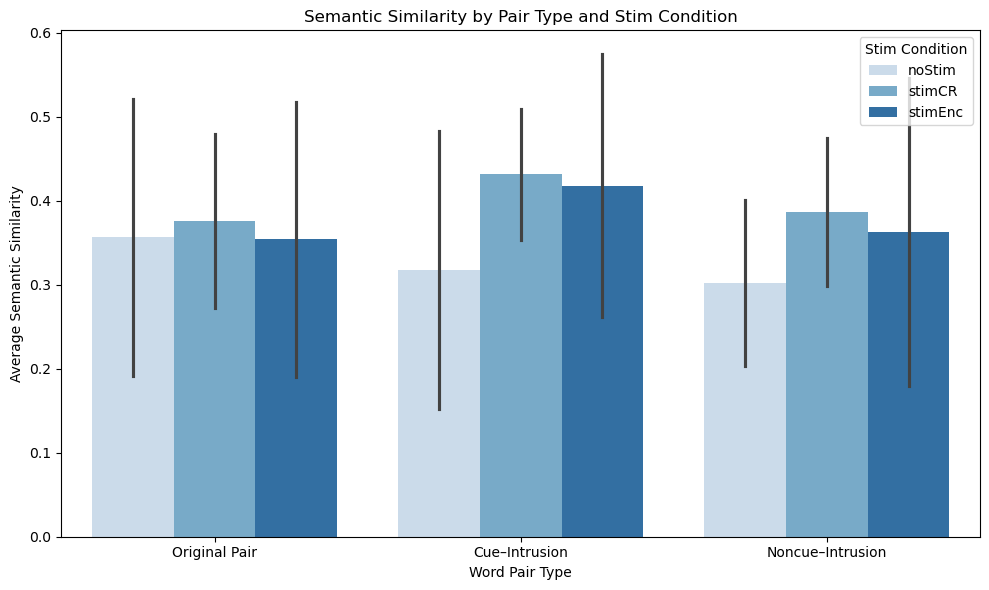

In [291]:
# Step 1: Melt the dataframe — reshape it to long format
melted = pd.melt(
    intrusion_df,
    id_vars=['stim_condition'],
    value_vars=['similarity', 'cue_intrusion_sim', 'nonCue_intrusion_sim'],
    var_name='pair_type',
    value_name='similarity_value'
)

# Step 2: Clean up the labels for pair_type for clarity (optional)
label_map = {
    'similarity': 'Original Pair',
    'cue_intrusion_sim': 'Cue–Intrusion',
    'nonCue_intrusion_sim': 'Noncue–Intrusion'
}
melted['pair_type'] = melted['pair_type'].map(label_map)

# Step 3: Drop rows where similarity is NaN (if any)
melted = melted.dropna(subset=['similarity_value'])

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted,
    x='pair_type',
    y='similarity_value',
    hue='stim_condition',
    errorbar='sd',
    palette=sns.color_palette("Blues", 3)
)
plt.title("Semantic Similarity by Pair Type and Stim Condition")
plt.xlabel("Word Pair Type")
plt.ylabel("Average Semantic Similarity")
plt.legend(title="Stim Condition")
plt.tight_layout()
plt.show()

In [ ]:
# Make a copy to edit and analize across different subjects
!cp Semantic_Similarity_allSubjects.ipynb Semantic_Similarity_allSubjects.ipynb

In [ ]:
# 

In [ ]:
sem_sim_vec=[]
for row in temp_enc_cr_df:
    two_items=row["pairedWords"]
    
    value=semantic_sim...(0.3)
    sem_sim_vec = sem_sim_vec+value
    len(sem_sim_vec)==len(temp_enc_cr_df)
    
temp_enc_cr_df['sem_sim_value']=sem_sim_vec